Bibliotecas necessárias e carregamento da base de dados

In [2]:
from torchvision import datasets
import torch
data_folder = ''
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100%|██████████████████████████████████████| 26.4M/26.4M [00:04<00:00, 6.33MB/s]
100%|███████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 136kB/s]
100%|██████████████████████████████████████| 4.42M/4.42M [00:02<00:00, 1.69MB/s]
100%|██████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]


In [3]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

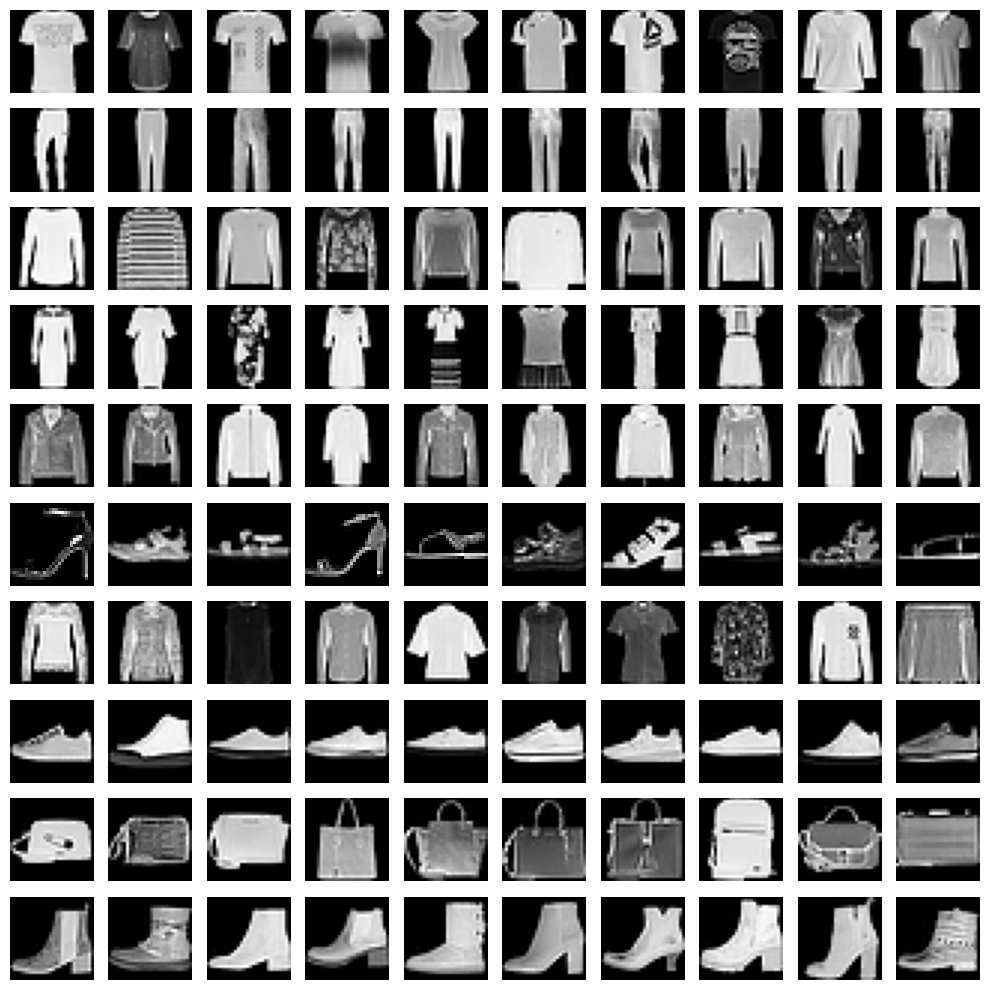

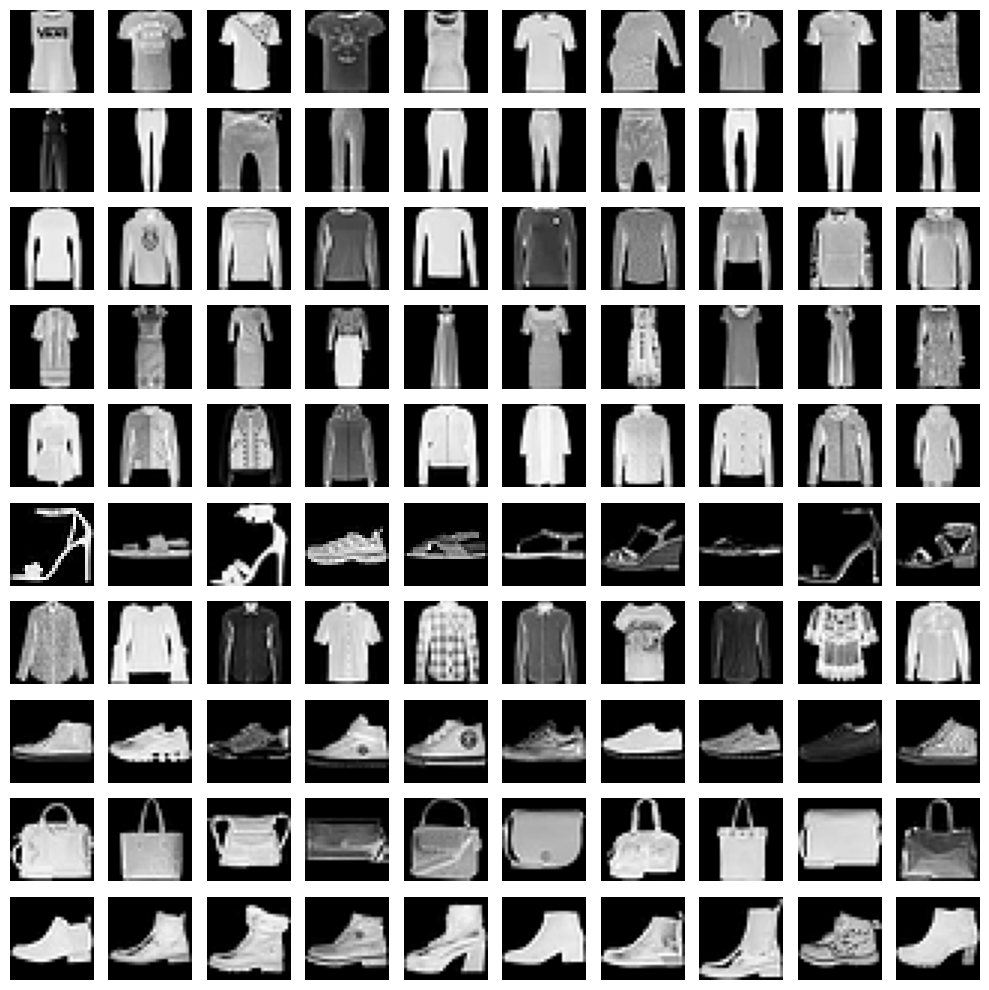

In [8]:
R, C = len(tr_targets.unique()), 10  
fig, ax = plt.subplots(R, C, figsize=(10, 10))  

for label_class, plot_row in enumerate(ax):  
    label_x_rows = np.where(tr_targets == label_class)[0]  

    for plot_cell in plot_row: 
        plot_cell.grid(False); plot_cell.axis('off')  
        ix = np.random.choice(label_x_rows)  
        x, y = tr_images[ix], tr_targets[ix]  
        plot_cell.imshow(x, cmap='gray')  

plt.tight_layout() 
plt.show()

In [9]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets

In [10]:
class FMNISTDataset(Dataset):  
    def __init__(self, x, y):
        x = x.float()  
        
        x = x.view(-1, 28*28)  
        self.x, self.y = x, y  

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]  
        return x.to(device), y.to(device)  
    def __len__(self):
        return len(self.x)  

In [11]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [12]:
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000,10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr = 1e-2)
    return model, loss_fn, optimizer

In [13]:
@torch.no_grad()
def accuracy_fn(x,y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [15]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()  
    prediction = model(x)  
    batch_loss = loss_fn(prediction, y)  
    batch_loss.backward()  
    optimizer.step()  
    
    optimizer.zero_grad()  
    return batch_loss.item()  

In [16]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [17]:
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy_fn(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


In [23]:
epochs = np.arange(5) + 1 
plt.figure(figsize=(20, 5))  

plt.subplot(121)
plt.title('Loss value over increasing epochs')  
plt.plot(epochs, losses, label='Training Loss')  
plt.legend()  

plt.subplot(122)
plt.title('Accuracy value over increasing epochs')  
plt.plot(epochs, accuracies, label='Training Accuracy') 

yticks = plt.gca().get_yticks()  
plt.gca().set_yticks(yticks)  
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in yticks]) 
plt.legend()  